In [1]:
import sys

from sndstraj.utils.helpers import start_sc, start_bigoudi_sc
from sndstraj.cohorts.describeCohort import describe_cohort, describe_demographics, age_pyramide_plot, add_age
from sndstraj.cohorts.describeCohort import stratified_sampling_on_gender_age

%load_ext autoreload
%autoreload 2

## Doit être utilisé sur bigoudi au lieu de start_sc
#sqlContext = start_bigoudi_sc(4, local = True)
sqlContext = start_sc(4)

In [2]:
import os 
import pyspark.sql.functions as func

Now that we have a target cohort, ie a cohort of interest, we can study in detail this cohort and build a control cohort that will be used as negative examples for the prediction models.

In [3]:
path2target_events = "data/target_cohort/target_events/"
path2target_patients = "data/target_cohort/target_patients/"

target_events = sqlContext.read.parquet(path2target_events)
target_patients = sqlContext.read.parquet(path2target_patients)

In [4]:
target_events.show(2)

+---------+---------------+-----+--------+------+-------------------+----+
|patientID|       category|value| groupID|weight|              start| end|
+---------+---------------+-----+--------+------+-------------------+----+
|    pID-6|main_diagnostic|  J44|pfsID-82|   0.0|2017-06-25 02:00:00|null|
|   pID-16|main_diagnostic|  J44|pfsID-90|   0.0|2017-04-14 02:00:00|null|
+---------+---------------+-----+--------+------+-------------------+----+
only showing top 2 rows



In [5]:
target_events.groupBy('category').count().show(5)

+---------------+-----+
|       category|count|
+---------------+-----+
|       dcir_act| 6031|
|main_diagnostic| 6193|
|           drug| 5275|
+---------------+-----+



### Description of the cohort

In [6]:
### TODO, clean because a little dirty 
described_fields = {
    'category_of_events': True,
    'categorical_top_k': {'main_diagnostic': 4, 'dcir_act': 7}
}

cohort_description = describe_cohort(target_events, described_fields)
print(cohort_description.keys())

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Cohort with 1099 patients and 17499 events
Computing nb_category_of_events per patients
Computing top_k with k = 10
Computed in 0:00:09.758006
dict_keys(['nb_events', 'nb_patients', 'nb_events_described', 'nb_category_of_events', 'top_k_fields'])


In [7]:
# nomnbre d'événements toute catégorie par personne
cohort_description['nb_events_described']

count
count  1099.000000
mean     15.922657
std       3.859371
min       6.000000
1%        7.000000
25%      13.000000
50%      16.000000
75%      18.000000
99%      26.000000
max      29.000000

In [8]:
# Nombre d'événements par catégorie
cohort_description['nb_category_of_events']

dcir_act         drug  main_diagnostic
count  1099.000000  1099.000000      1099.000000
mean      5.487716     4.799818         5.635123
std       2.357135     1.938010         2.419691
min       0.000000     1.000000         0.000000
1%        1.000000     1.000000         1.000000
25%       4.000000     3.000000         4.000000
50%       5.000000     5.000000         6.000000
75%       7.000000     6.000000         7.000000
99%      12.000000    10.000000        11.000000
max      14.000000    12.000000        16.000000

In [9]:
cohort_description['top_k_fields']['main_diagnostic']

main_diagnostic_value  main_diagnostic_count main_diagnostic_concept_name
0                   J44                   4136                          NaN
1                   J96                   1046                          NaN
2                   J18                   1011                          NaN

In [10]:
cohort_description['top_k_fields']['dcir_act']

dcir_act_value  dcir_act_count dcir_act_concept_name
0    06.01.07.04            6031                   NaN

### Explore demographics

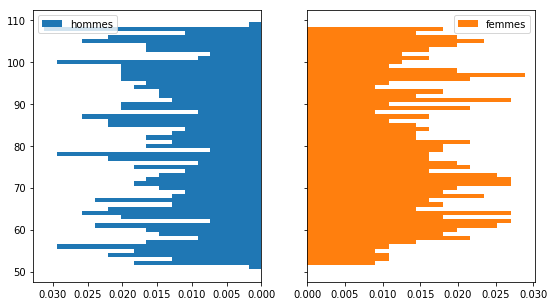

In [11]:
target_age_buckets = age_pyramide_plot(target_patients, bucket_size=1)

In [12]:
target_demographics = describe_demographics(target_patients)

Taille population : 1099
Part femmes : 544/1099 = 0.4950
Part DCD : 569/1099 = 0.5177


In [13]:
target_demographics['date_description']

birth_year  death_year
count      1099.0       569.0
mean       1938.0      2002.0
std          16.0        11.0
min        1910.0      1968.0
1%         1910.0      1975.0
25%        1923.0      1996.0
50%        1939.0      2004.0
75%        1952.0      2012.0
99%        1966.0      2019.0
max        1967.0      2019.0

## Select Controls

We can use startified sampling on sex and age to build the control cohort. The function `stratify_sampling_on_gender_age` leverages the `sampleBy` function of spark.sql to sample on age

In [14]:
negative_patients = sqlContext.read.parquet('data/population_cohort/population_patients/').join(
    target_patients.select('patientID'),
    'patientID',
    'left_anti')
negative_patients.count()

4200

In [15]:
negative_demographics = describe_demographics(negative_patients)

Taille population : 4200
Part femmes : 2114/4200 = 0.5033
Part DCD : 2199/4200 = 0.5236


In [16]:
control_patients =  stratified_sampling_on_gender_age(
    control_patients=negative_patients,
    target_patients=target_patients,
    bucket_size = 2,
    target_ratio_fraction=2)

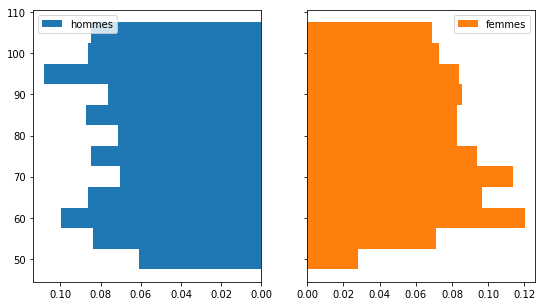

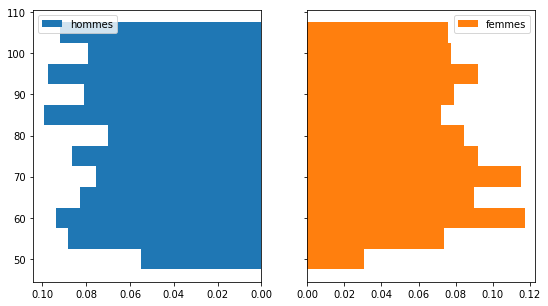

In [17]:
# Control that we have close distributions between control and target on the cofactors 
control_age_buckets = age_pyramide_plot(control_patients, bucket_size=5)
target_age_buckets = age_pyramide_plot(target_patients,bucket_size=5)

In [18]:
control_demographics = describe_demographics(control_patients)
target_demographics = describe_demographics(target_patients)

Taille population : 2163
Part femmes : 1064/2163 = 0.4919
Part DCD : 1110/2163 = 0.5132
Taille population : 1099
Part femmes : 544/1099 = 0.4950
Part DCD : 569/1099 = 0.5177


## Create control dataset

In [19]:
path2control_events = "data/control_cohort/control_events/"
path2control_patients = "data/control_cohort/control_patients/"

path2population_events = "data/snds2vec_data/low_granumarity_cohort/"

control_events = sqlContext.read.parquet(path2population_events).join(
    control_patients.select('patientID'), 'patientID', 'inner')

control_events.write.parquet(path2control_events, mode='overwrite')
control_patients.write.parquet(path2control_patients, mode='overwrite')